# **Imports** 📓

In [ ]:
import os
import sys
import shutil
import gc
import hashlib
from glob import glob
from pprint import pprint
from collections import Counter, defaultdict


import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns


from PIL import Image
import cv2
from tensorflow.keras.utils import load_img


from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


 # **EDA** 📊

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/rahasahly/oct2017")

#71ce9a4fe0f0ca4ac0c01ac12cbc497a

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Rha Sahly
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rahasahly/oct2017


100%|██████████| 5.41G/5.41G [00:43<00:00, 132MB/s]


In [ ]:
#number of images in each file
#for training file
training_dataset= tf.keras.preprocessing.image_dataset_from_directory("/content/oct2017/OCT2017/train")
#for testing file
test_dataset= tf.keras.preprocessing.image_dataset_from_directory("/content/oct2017/OCT2017/test")


Found 83484 files belonging to 4 classes.
Found 1000 files belonging to 4 classes.


In [ ]:
training_dir = "/content/oct2017/OCT2017/train"
testing_dir = "/content/oct2017/OCT2017/test"

image_paths = [] # for images paths
labels = []      #their corresponding labels


for label_dir in os.listdir(training_dir):
    label_path = os.path.join(training_dir, label_dir)
    if os.path.isdir(label_path):
        for img_file in os.listdir(label_path):
            image_paths.append(os.path.join(label_path, img_file))
            labels.append(label_dir)





In [ ]:
test_image_paths = []
test_labels = []

for label_dir in os.listdir(testing_dir):
    label_path = os.path.join(testing_dir, label_dir)
    if os.path.isdir(label_path):
        for img_file in os.listdir(label_path):
            test_image_paths.append(os.path.join(label_path, img_file))
            test_labels.append(label_dir)


**converting labels to integers for easier handling** + **ensure unified mapping for consistency**

In [ ]:
unique_train_labels = list(set(labels)) #unique labels only  , normal , cnv , ...
train_label_to_index = {label: idx for idx, label in enumerate(unique_train_labels)} #maps class to index , {'NORMAL': 0, 'CNV': 1}
train_index_to_label = {idx: label for label, idx in train_label_to_index.items()}  #the oppisite {0: 'NORMAL'}




#same for ttsing

unique_test_labels = list(set(test_labels))
test_label_to_index = {label: idx for idx, label in enumerate(unique_test_labels)}
test_index_to_label = {idx: label for label, idx in test_label_to_index.items()}



#combine unique string labels to ensure unified mapping

valid_labels = list(set(labels + test_labels))
label_to_index = {label: idx for idx, label in enumerate(valid_labels)}



#apply
train_labels = [label_to_index[label] for label in labels]
final_test_labels = [label_to_index[label] for label in test_labels]



#check
print("Unified Label to Index Mapping:", label_to_index)
print("Unique labels in training labels:", set(train_labels))
print("Unique labels in final test labels:", set(final_test_labels))

Unified Label to Index Mapping: {'DME': 0, 'NORMAL': 1, 'CNV': 2, 'DRUSEN': 3}
Unique labels in training labels: {0, 1, 2, 3}
Unique labels in final test labels: {0, 1, 2, 3}


# **Detect and remove duplicates**

In [ ]:
def compute_image_hash(image_path):
    with open(image_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def remove_duplicates(image_paths, labels):
    seen_hashes = set()
    unique_image_paths = []
    unique_labels = []
    duplicates = []

    for i, image_path in enumerate(image_paths):
        image_hash = compute_image_hash(image_path)
        if image_hash not in seen_hashes:
            seen_hashes.add(image_hash)
            unique_image_paths.append(image_path)
            unique_labels.append(labels[i])
        else:
            duplicates.append(image_path)

    print(f"Found {len(duplicates)} duplicate images.")
    return unique_image_paths, unique_labels, duplicates



In [ ]:
#applying the  DR
print("Removing duplicates in the dataset...")
unique_image_paths, unique_labels, duplicates = remove_duplicates(image_paths, labels)

#updating
image_paths = unique_image_paths
labels = unique_labels

assert len(image_paths) == len(labels), "Mismatch between image paths and labels after duplicate removal"

print(f"Dataset size after duplicate removal: {len(image_paths)} images.")
print(f"Unique paths after duplicate removal: {len(set(image_paths))}")
print(f"Number of labels after duplicate removal: {len(labels)}")
print(f"Mismatch: {len(labels) != len(image_paths)}")


Removing duplicates in the dataset...
Found 6987 duplicate images.
Dataset size after duplicate removal: 76497 images.
Unique paths after duplicate removal: 76497
Number of labels after duplicate removal: 76497
Mismatch: False


**classes distrubtion to check class imbalance**

In [ ]:
train_class_counts = Counter(unique_labels)

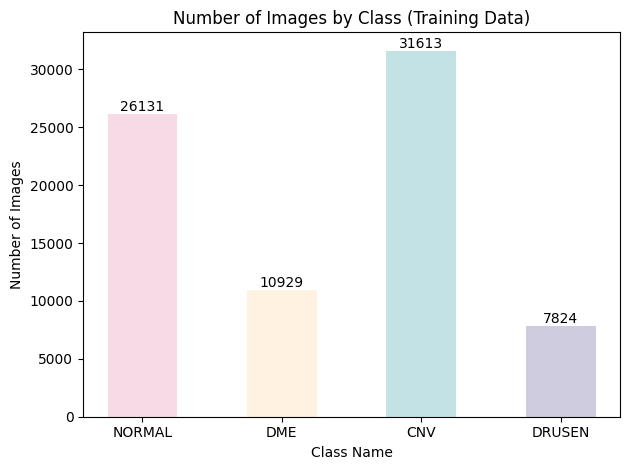

In [ ]:
# Directly use the class names from train_class_counts
train_class_counts_named = train_class_counts

# Custom pastel colors for the bars
colors = ['#F7DAE5', '#FFF2E1', '#C3E2E6', '#D0CCE0']

# Plot
plt.bar(train_class_counts_named.keys(), train_class_counts_named.values(), color=colors, width=0.5)
plt.title("Number of Images by Class (Training Data)")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")

# Add count labels to the bars
for i, (class_name, count) in enumerate(train_class_counts_named.items()):
    plt.text(i, count, str(count), color='black', ha='center', va='bottom')

plt.tight_layout()
plt.show()




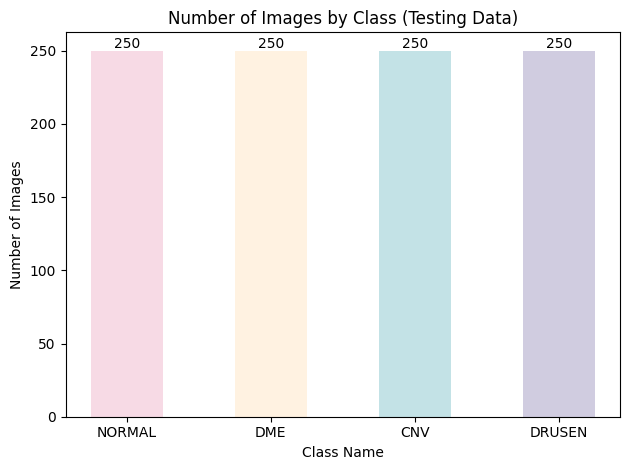

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the number of images in each class for the testing data
test_class_counts = Counter(final_test_labels)

# Map numerical class indices to class names using `index_to_label`
test_class_counts_named = {test_index_to_label[key]: value for key, value in test_class_counts.items()}

# Plot
colors = ['#F7DAE5', '#FFF2E1', '#C3E2E6', '#D0CCE0']  # Custom pastel colors
plt.bar(test_class_counts_named.keys(), test_class_counts_named.values(), color=colors, width=0.5)
plt.title("Number of Images by Class (Testing Data)")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")

# Add count labels to the bars
for i, (class_name, count) in enumerate(test_class_counts_named.items()):
    plt.text(i, count, str(count), color='black', ha='center', va='bottom')

plt.tight_layout()
plt.show()




# **splitting data to 70/15/15 and combining original testing with new one**

In [ ]:

train_paths, remaining_paths, train_labels, remaining_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)


test_paths, val_paths, test_labels, val_labels = train_test_split(
    remaining_paths, remaining_labels, test_size=1/3, stratify=remaining_labels, random_state=42
)

In [ ]:
from collections import Counter
print(Counter(train_labels))
#53k

Counter({'CNV': 22129, 'NORMAL': 18291, 'DME': 7650, 'DRUSEN': 5477})


In [ ]:
import os

def load_data_from_directory(directory_path):
    """Load image paths and labels from a directory."""
    image_paths = []
    labels = []
    for label_dir in os.listdir(directory_path):
        label_path = os.path.join(directory_path, label_dir)
        if os.path.isdir(label_path):  # Ensure it's a directory
            for img_file in os.listdir(label_path):
                image_paths.append(os.path.join(label_path, img_file))
                labels.append(label_dir)  # Use directory name as label
    return image_paths, labels


In [ ]:
def create_label_mapping(*label_sets):

    # Combine all labels from the provided label sets into a single set of unique labels
    all_labels = list(set(label for labels in label_sets for label in labels))

    # Create a dictionary mapping each unique label to an integer index
    label_to_index = {label: idx for idx, label in enumerate(all_labels)}

    # Create the reverse mapping (index to label)
    index_to_label = {idx: label for label, idx in label_to_index.items()}

    return label_to_index, index_to_label


In [ ]:
original_test_paths, original_test_labels = load_data_from_directory(testing_dir)

# Create unified label mapping
label_to_index, index_to_label = create_label_mapping(
    train_labels, val_labels, test_labels, original_test_labels
)

# Map string labels to integer indices
train_labels = [label_to_index[label] for label in train_labels]
val_labels = [label_to_index[label] for label in val_labels]
test_labels = [label_to_index[label] for label in test_labels]
original_test_labels = [label_to_index[label] for label in original_test_labels]

#merge test
final_test_paths = test_paths + original_test_paths
final_test_labels = test_labels + original_test_labels



In [ ]:
print(f"Training paths: {len(train_paths)}")
print(f"Validation paths: {len(val_paths)}")
print(f"Testing paths: {len(final_test_paths)}")


Training paths: 53547
Validation paths: 7650
Testing paths: 16300


In [ ]:
print("Training class distribution:", Counter(train_labels))
print("Validation class distribution:", Counter(val_labels))
print("Testing class distribution:", Counter(final_test_labels))


Training class distribution: Counter({2: 22129, 1: 18291, 0: 7650, 3: 5477})
Validation class distribution: Counter({2: 3161, 1: 2613, 0: 1093, 3: 783})
Testing class distribution: Counter({2: 6573, 1: 5477, 0: 2436, 3: 1814})


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((final_test_paths, final_test_labels))


#check
print(f"Training dataset: {len(list(train_dataset))} samples")
print(f"Validation dataset: {len(list(val_dataset))} samples")
print(f"Testing dataset: {len(list(test_dataset))} samples")



Training dataset: 53547 samples
Validation dataset: 7650 samples
Testing dataset: 16300 samples


# **classes distrubtion**

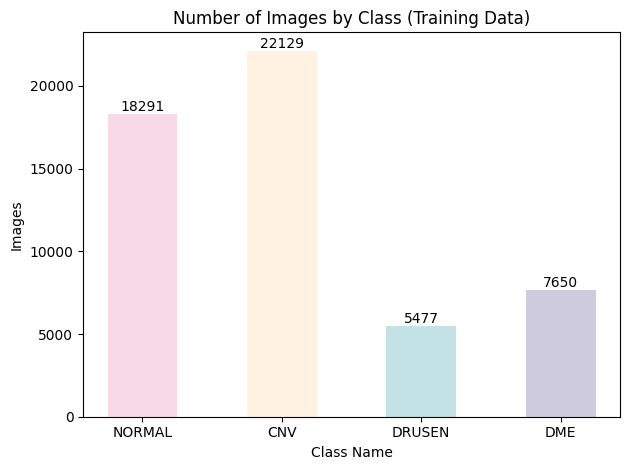

In [ ]:
from collections import Counter

# Count the number of images in each class for the training data
train_class_counts = Counter(train_labels)

# Map numerical class indices to class names
train_class_counts_named = {index_to_label[key]: value for key, value in train_class_counts.items()}

# Plot
colors = ['#F7DAE5', '#FFF2E1', '#C3E2E6', '#D0CCE0']
plt.bar(train_class_counts_named.keys(), train_class_counts_named.values(), color=colors, width=0.5)
plt.title("Number of Images by Class (Training Data)")
plt.xlabel('Class Name')
plt.ylabel('Images')

# Add count labels to the bars
for i, (class_name, count) in enumerate(train_class_counts_named.items()):
    plt.text(i, count, str(count), color='black', ha='center', va='bottom')

plt.tight_layout()
plt.show()




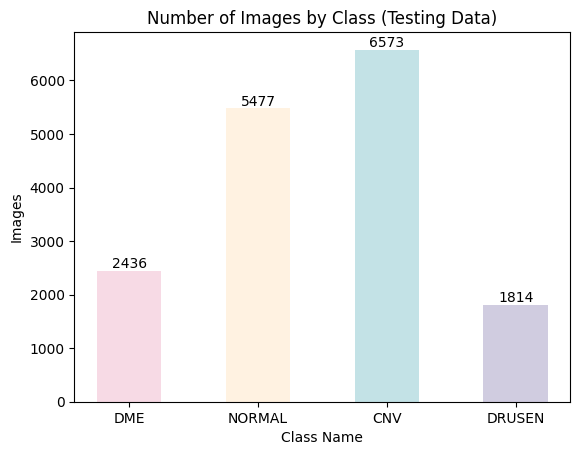

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the number of images in each class for testing data
test_class_counts = Counter(final_test_labels)
test_class_counts_named = {index_to_label[key]: value for key, value in test_class_counts.items()}


# Plot the distribution
colors = ['#F7DAE5', '#FFF2E1', '#C3E2E6', '#D0CCE0']
plt.bar(test_class_counts_named.keys(), test_class_counts_named.values(), color=colors, width=0.5)
plt.title("Number of Images by Class (Testing Data)")
plt.xlabel("Class Name")
plt.ylabel("Images")

# Add count labels to the bars
for i, (class_name, count) in enumerate(test_class_counts_named.items()):
    plt.text(i, count, str(count), color='black', ha='center', va='bottom')

plt.show()



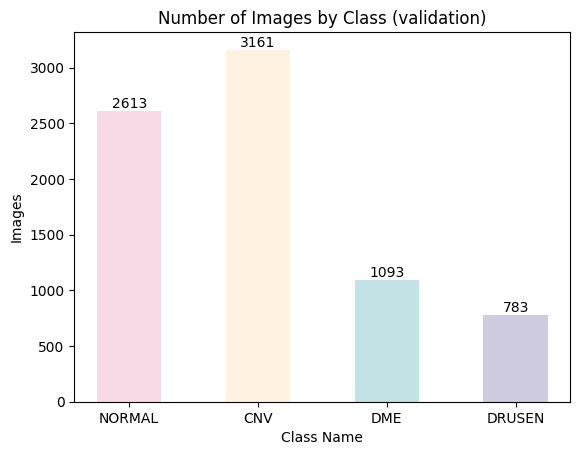

In [ ]:
# Count the number of images in each class for testing data
val_class_counts = Counter( val_labels)

# Map numerical labels to class names
val_class_counts_named = {index_to_label[key]: value for key, value in val_class_counts.items()}

# Plot the distribution
colors = ['#F7DAE5', '#FFF2E1', '#C3E2E6', '#D0CCE0']
plt.bar(val_class_counts_named.keys(), val_class_counts_named.values(), color=colors, width=0.5)
plt.title("Number of Images by Class (validation)")
plt.xlabel("Class Name")
plt.ylabel("Images")

# Add count labels to the bars
for i, (class_name, count) in enumerate(val_class_counts_named.items()):
    plt.text(i, count, str(count), color='black', ha='center', va='bottom')

plt.show()


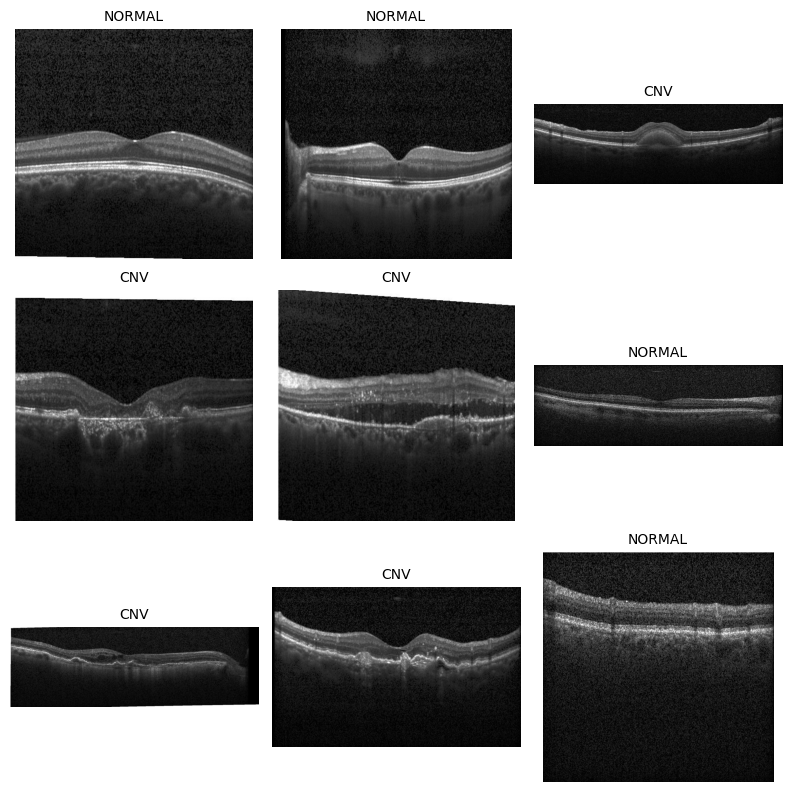

In [ ]:
# Create a grid layout with consistent spacing and a professional appearance
fig, axes = plt.subplots(3, 3, figsize=(8, 8), facecolor="white")  # Create a 3x3 grid
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, (image_path, label) in enumerate(train_dataset.take(9)):
    img = load_img(image_path.numpy().decode('utf-8'))  # Load the image from the file path
    axes[i].imshow(img, cmap="gray")  # Display the image in grayscale
    class_name = index_to_label[label.numpy()]  # Map numerical label to class name
    axes[i].set_title(f"{class_name}", fontsize=10, color="black")  # Set title for each image
    axes[i].axis("off")  # Turn off axis for a cleaner look

# Add padding and spacing for neatness
plt.tight_layout(pad=1.0)  # Add padding between the subplots
plt.show()




# **images size**

In [ ]:
image_sizes = []

# Process the first 100 images from the training dataset
for image_path, _ in train_dataset.take(100):  # Take 100 images
    img_path = image_path.numpy().decode('utf-8')  # Decode the file path
    image = tf.io.read_file(img_path)  # Read the image file
    image = tf.image.decode_jpeg(image, channels=1)  # Decode as grayscale image (1 channel)

    # Get the image size (height, width)
    height, width = image.shape[:2]
    image_sizes.append((height, width))

# Find unique image sizes
unique_sizes = set(image_sizes)

print("Unique image sizes:", unique_sizes)




Unique image sizes: {(496, 768), (512, 512), (496, 512), (496, 1536)}


# **Preproccesing**

In [ ]:
def refine_cropping(image):

    image = tf.cast(image, tf.float32) #convert image to float32 for histogram



    histogram = tf.histogram_fixed_width(image, [0, 255], nbins=256)   #calc histo to identify peak
    peak_intensity = tf.argmax(histogram[-50:]) + 175  # focus on near white



    #dynamic threshold slightly below the peak
    threshold = tf.cast(peak_intensity - 10, tf.float32)  #slightly below the peak
    binary_mask = tf.where(image >= threshold, 255.0, 0.0)



    # Step 4: Identify non-white coordinates
    non_white_coords = tf.where(binary_mask < 255.0)

    ymin = tf.cast(tf.reduce_min(non_white_coords[:, 0]), tf.int32)
    ymax = tf.cast(tf.reduce_max(non_white_coords[:, 0]), tf.int32)
    xmin = tf.cast(tf.reduce_min(non_white_coords[:, 1]), tf.int32)
    xmax = tf.cast(tf.reduce_max(non_white_coords[:, 1]), tf.int32)



    #synamically expand margins based on the region size
    image_shape = tf.shape(image)
    margin = tf.minimum(20, tf.minimum(ymin, xmin))
    ymin = tf.maximum(0, ymin - margin)
    ymax = tf.minimum(image_shape[0], ymax + margin)
    xmin = tf.maximum(0, xmin - margin)
    xmax = tf.minimum(image_shape[1], xmax + margin)

    #crop
    cropped_image = tf.image.crop_to_bounding_box(
        tf.cast(image, tf.uint8), ymin, xmin, ymax - ymin, xmax - xmin
    )

    return cropped_image



In [ ]:
def preprocess_image(image_path, label):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)



    cropped_image = refine_cropping(image)


    resized_image = tf.image.resize(cropped_image, [224, 224], method=tf.image.ResizeMethod.BICUBIC) #resize using bicubic


    normalized_image = resized_image / 255.0 #normiliaztion

    rgb_image = tf.image.grayscale_to_rgb(normalized_image) # convert to rgb for vgg

    return rgb_image, label



In [ ]:
#apply the preproccesing on the entire dataset

train_dataset1 = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset1 = val_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset1 = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

#batch + prefetch for better
train_dataset1 = train_dataset1.batch(16).prefetch(tf.data.AUTOTUNE)
val_dataset1 = val_dataset1.batch(16).prefetch(tf.data.AUTOTUNE)
test_dataset1 = test_dataset1.batch(16).prefetch(tf.data.AUTOTUNE)



**visualization**

In [ ]:
#same preprocessing but with visualization

def visualize_improved_preprocessing(image_path):


    original_image = tf.io.read_file(image_path)
    original_image = tf.image.decode_jpeg(original_image, channels=1)


    cropped_image = refine_cropping(original_image)


    resized_image = tf.image.resize(cropped_image, [224, 224], method=tf.image.ResizeMethod.BICUBIC)
    normalized_image = resized_image / 255.0




    import matplotlib.pyplot as plt
    plt.figure(figsize=(16, 6), facecolor="black")

    plt.subplot(1, 4, 1)
    plt.imshow(original_image.numpy().squeeze(), cmap='gray')
    plt.title("a) Original image", color="white")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(cropped_image.numpy().squeeze(), cmap='gray')
    plt.title("b) Removed white border", color="white")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(resized_image.numpy().squeeze(), cmap='gray')
    plt.title("c) Resolution transformation", color="white")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(normalized_image.numpy().squeeze(), cmap='gray')
    plt.title("d) Data normalization", color="white")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


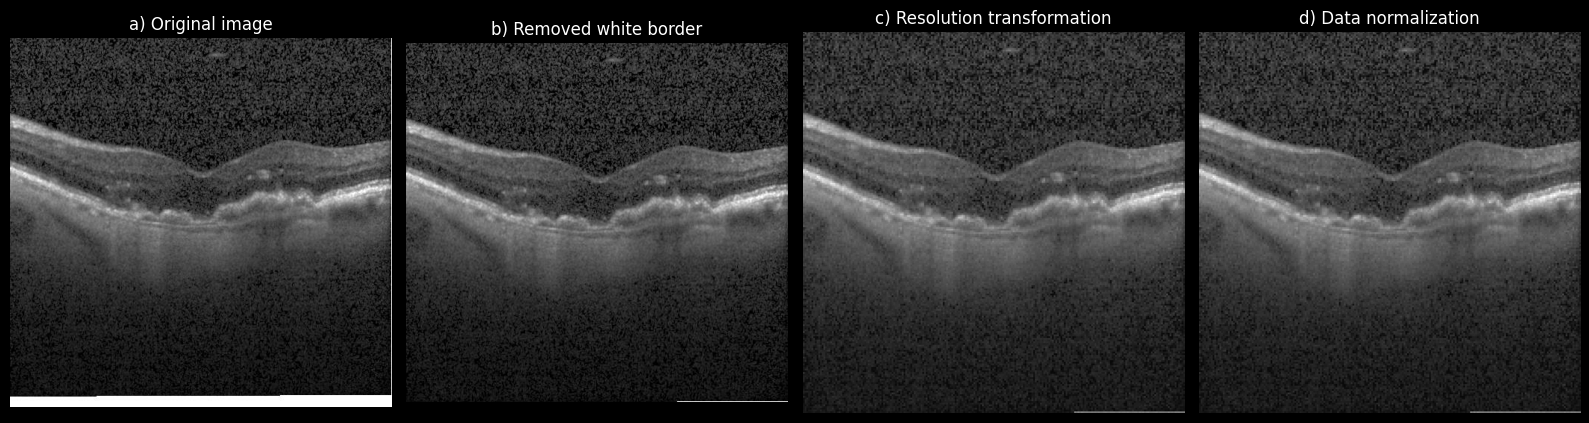

In [ ]:
visualize_improved_preprocessing("/content/oct2017/OCT2017/train/CNV/CNV-103044-102.jpeg")

In [ ]:

for image, label in train_dataset1.take(1):
    print(f"Image shape: {image.shape}")
    print(f"Label shape: {label.shape}")



Image shape: (16, 224, 224, 3)
Label shape: (16,)


In [ ]:
train_size = tf.data.experimental.cardinality(train_dataset1).numpy()
val_size = tf.data.experimental.cardinality(val_dataset1).numpy()

print(f"Training dataset size: {train_size} batches")
print(f"Validation dataset size: {val_size} batches")

Training dataset size: 3347 batches
Validation dataset size: 479 batches


**class weights calc**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

unique_classes = np.unique(train_labels)


class_weights = compute_class_weight(
    class_weight="balanced",
    classes=unique_classes,
    y=train_labels
)


class_weight_dict = {
    class_idx: weight for class_idx, weight in zip(unique_classes, class_weights)
}

print("Class weights:", class_weight_dict)


Class weights: {0: 1.7499019607843138, 1: 0.7318763326226013, 2: 0.6049414795065299, 3: 2.444175643600511}


**train model on preprocessed data**

In [ ]:
from tensorflow.keras.models import load_model

# Load the model from the file
model = load_model('best_vgg19_model.keras')
print("Model loaded successfully!")



Model loaded successfully!


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
class_weight_dict = {
    0: 0.8,
    1: 3.0,
    2: 2.5,
    3: 0.7
}


#unfreezing last 10 layers + using class weight

for layer in model.layers[-10:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_dataset1,
    validation_data=val_dataset1,
    epochs=10,
    class_weight=class_weight_dict
)


Epoch 1/10
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 164s 44ms/step - accuracy: 0.8664 - loss: 0.8365 - val_accuracy: 0.8850 - val_loss: 0.6902
Epoch 2/10
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 131s 39ms/step - accuracy: 0.9404 - loss: 0.4869 - val_accuracy: 0.9386 - val_loss: 0.4357
Epoch 3/10
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 131s 39ms/step - accuracy: 0.9577 - loss: 0.3664 - val_accuracy: 0.9464 - val_loss: 0.3659
Epoch 4/10
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 131s 39ms/step - accuracy: 0.9687 - loss: 0.2796 - val_accuracy: 0.9447 - val_loss: 0.3501
Epoch 5/10
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 131s 39ms/step - accuracy: 0.9762 - loss: 0.2158 - val_accuracy: 0.9603 - val_loss: 0.2569
Epoch 6/10
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 131s 39ms/step - accuracy: 0.9821 - loss: 0.1679 - val_accuracy: 0.9314 - val_loss: 0.3598
Epoch 7/10
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 131s 39ms/step - accuracy: 0.9837 - loss: 0.1387 - val_accuracy: 0.9485 - val_loss: 0.2673
Epoch 8/10
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 131s 39ms/step - accuracy: 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.9525 - loss: 0.2345
Test Loss: 0.24061346054077148
Test Accuracy: 0.9525153636932373


In [ ]:
val_loss, val_accuracy = model.evaluate(val_dataset1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

479/479 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9521 - loss: 0.2501
Validation Loss: 0.2353
Validation Accuracy: 0.9524


In [ ]:
test_image_path = "path/to/image.jpg"
processed_image = preprocess_image(test_image_path)
processed_image = np.expand_dims(processed_image, axis=0)

prediction = model.predict(processed_image)
predicted_class = np.argmax(prediction, axis=1)

print(f"Predicted Class: {predicted_class}")
print(f"Predicted Class Name: {index_to_label[predicted_class[0]]}")


TypeError: preprocess_image() missing 1 required positional argument: 'label'

In [ ]:
import json

# Save the training history as JSON
with open("training_results.json", "w") as file:
    json.dump(history.history, file)


**model performance visulization**

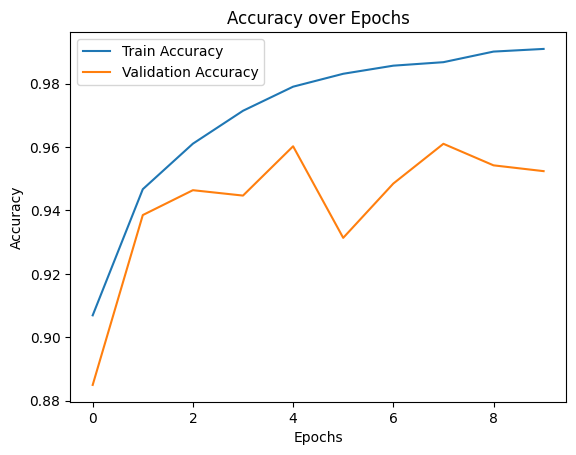

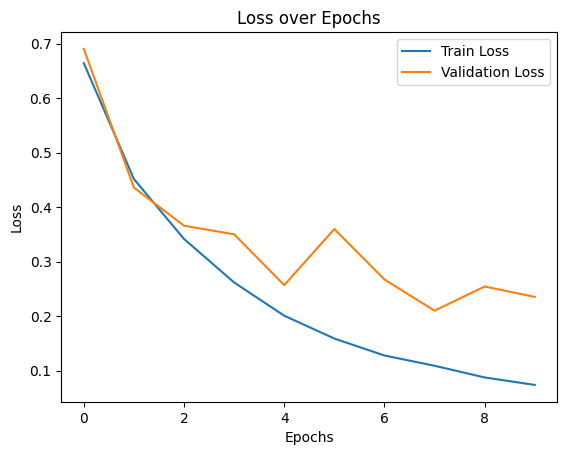

In [ ]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

[[2212  128   96    0]
 [  19 5427   16   15]
 [  16    7 6522   28]
 [   4  135  310 1365]]


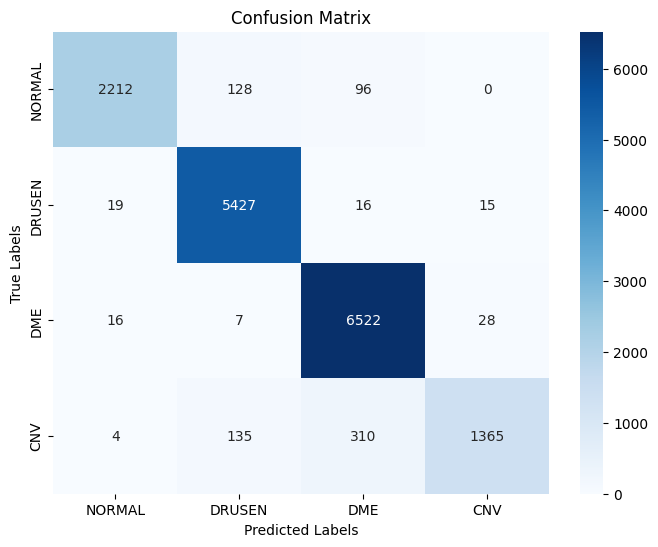

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




y_true = []
y_pred = []

# Loop through the test dataset to collect true labels and predictions
for images, labels in test_dataset1:
    y_true.extend(labels.numpy())  # Append true labels
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))  # Append predicted labels



cm = confusion_matrix(y_true, y_pred)
print(cm)



import matplotlib.pyplot as plt
import seaborn as sns


class_names = ["NORMAL", "DRUSEN", "DME", "CNV"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)


plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()



In [ ]:
print(len(y_true), len(y_pred))  # These should be equal


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print(f"Confusion Matrix:\n{cm}")
print(f"Total samples in confusion matrix: {cm.sum()}")  # Should be 16,300


In [ ]:
print(f"Data type of y_true: {type(y_true[0])}")
print(f"Data type of y_pred: {type(y_pred[0])}")


In [ ]:
y_true = [int(label) for label in y_true]
y_pred = [int(label) for label in y_pred]


In [ ]:
from collections import Counter

true_counts = Counter(y_true)
pred_counts = Counter(y_pred)

print(f"True label counts: {true_counts}")
print(f"Predicted label counts: {pred_counts}")


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=["NORMAL", "DRUSEN", "DME", "CNV"]))


              precision    recall  f1-score   support

      NORMAL       0.98      0.91      0.94      2436
      DRUSEN       0.95      0.99      0.97      5477
         DME       0.94      0.99      0.97      6573
         CNV       0.97      0.75      0.85      1814

    accuracy                           0.95     16300
   macro avg       0.96      0.91      0.93     16300
weighted avg       0.95      0.95      0.95     16300



Predictions shape: (16300, 4)
ROC-AUC Scores:
NORMAL: 0.9928
DRUSEN: 0.9971
DME: 0.9957
CNV: 0.9777


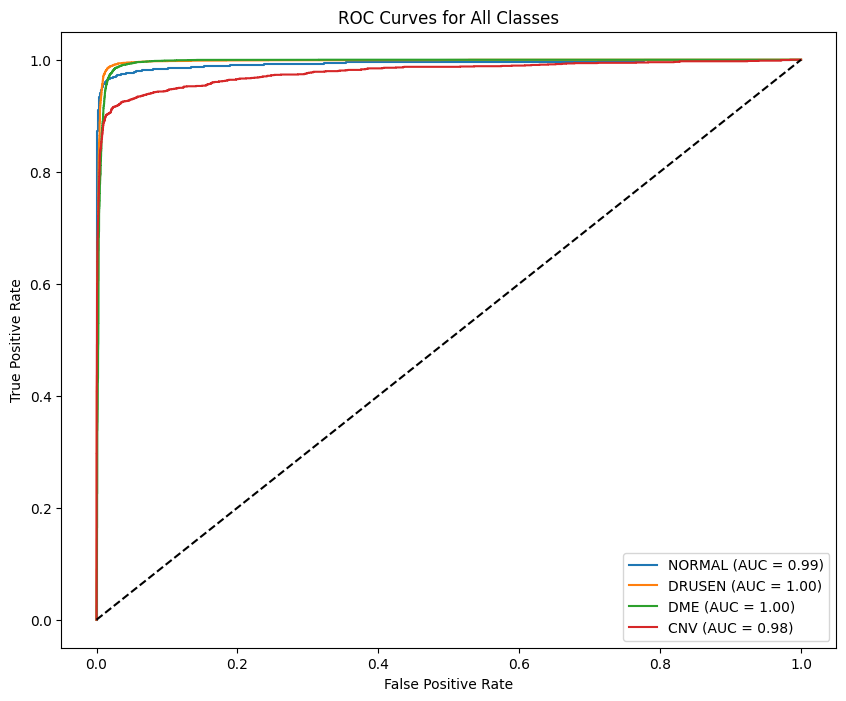

In [ ]:

from sklearn.metrics import roc_auc_score, roc_curve

class_labels = ["NORMAL", "DRUSEN", "DME", "CNV"]




# Get predictions (softmax probabilities)
predictions = model.predict(test_dataset1, verbose=0)
print(f"Predictions shape: {predictions.shape}")  # Should be (16300, 4)

# Ensure true labels are one-hot encoded
true_labels_one_hot = np.zeros((len(y_true), len(class_labels)))
true_labels_one_hot[np.arange(len(y_true)), y_true] = 1

# Compute ROC-AUC scores
roc_auc_scores = {}
for i, class_name in enumerate(class_labels):
    roc_auc_scores[class_name] = roc_auc_score(true_labels_one_hot[:, i], predictions[:, i])

# Print ROC-AUC scores
print("ROC-AUC Scores:")
for class_name, score in roc_auc_scores.items():
    print(f"{class_name}: {score:.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], predictions[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc_scores[class_name]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for All Classes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()



In [ ]:
print(model.summary())


In [ ]:
model.save('best_vgg19_model_OCT2.h5')  # Save the model in HDF5 format
print("Model saved successfully!")
